Hãy sử dụng dữ liệu được cung cấp trong email này (dữ liệu giá và khối
lượng của một vài mã cổ phiếu) để xây dựng một số mô hình dự đoán biến
động giá cổ phiếu.

Biến động giá cổ phiếu Δ = Giá cổ phiếu N (phút hoặc giờ hoặc ngày) sau - Giá cổ phiếu hiện tại.

In [2]:
!pip uninstall tensorflow # Fill Y to install latest tf and keras
!pip install tensorflow

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.15.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.15.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 87.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 85.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# I. XỬ LÝ THEO GIỜ
Ý tưởng: sử dụng dữ liệu delta của 100 giờ trước đó để dự đoán delta 10 giờ tiếp theo (N_max = 5).

In [22]:
# Tương tự thay đổi tên cho các mã khác
csv_dir = "PNJ.csv"
save_model_dir = "PNJ_min.keras"

## 1. Import dữ liệu (PNJ) và xử lý Pandas

In [4]:
df = pd.read_csv(csv_dir)
df.head(10)

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,PNJ,2/28/2018 9:15,78.14,78.99,78.14,78.99,270,0
1,PNJ,2/28/2018 9:16,78.94,78.94,78.94,78.94,10,0
2,PNJ,2/28/2018 9:19,78.14,78.14,78.14,78.14,283,0
3,PNJ,2/28/2018 9:20,78.14,78.14,78.14,78.14,480,0
4,PNJ,2/28/2018 9:21,78.14,78.14,78.14,78.14,146,0
5,PNJ,2/28/2018 9:22,78.09,78.09,78.09,78.09,100,0
6,PNJ,2/28/2018 9:23,78.09,78.14,78.09,78.14,210,0
7,PNJ,2/28/2018 9:24,78.14,78.14,78.14,78.14,32,0
8,PNJ,2/28/2018 9:25,78.75,78.75,78.75,78.75,20,0
9,PNJ,2/28/2018 9:26,78.75,78.75,78.75,78.75,50,0


***Nhận thấy cột ngày là object***

Ta dùng to_datetime để chuyển nó thành date time thực sự

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125309 entries, 0 to 125308
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Ticker         125309 non-null  object 
 1   Date/Time      125309 non-null  object 
 2   Open           125309 non-null  float64
 3   High           125309 non-null  float64
 4   Low            125309 non-null  float64
 5   Close          125309 non-null  float64
 6   Volume         125309 non-null  int64  
 7   Open Interest  125309 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 7.6+ MB


In [5]:
df["Date/Time"] = pd.to_datetime(df["Date/Time"])
df.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,PNJ,2018-02-28 09:15:00,78.14,78.99,78.14,78.99,270,0
1,PNJ,2018-02-28 09:16:00,78.94,78.94,78.94,78.94,10,0
2,PNJ,2018-02-28 09:19:00,78.14,78.14,78.14,78.14,283,0
3,PNJ,2018-02-28 09:20:00,78.14,78.14,78.14,78.14,480,0
4,PNJ,2018-02-28 09:21:00,78.14,78.14,78.14,78.14,146,0


***Bây giờ là trích xuất theo ngày và giờ***

Ta gộp các bản ghi trong một giờ lại với nhau. Giá cổ phiếu ứng với giờ đó sẽ là giá trị trung vị


In [6]:
# Tạo cột date
df["Date"] = df["Date/Time"].dt.date
df["Hour"] = df["Date/Time"].dt.hour
# pnj_df.head()

In [8]:
df

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest,Date,Hour
0,PNJ,2018-02-28 09:15:00,78.14,78.99,78.14,78.99,270,0,2018-02-28,9
1,PNJ,2018-02-28 09:16:00,78.94,78.94,78.94,78.94,10,0,2018-02-28,9
2,PNJ,2018-02-28 09:19:00,78.14,78.14,78.14,78.14,283,0,2018-02-28,9
3,PNJ,2018-02-28 09:20:00,78.14,78.14,78.14,78.14,480,0,2018-02-28,9
4,PNJ,2018-02-28 09:21:00,78.14,78.14,78.14,78.14,146,0,2018-02-28,9
...,...,...,...,...,...,...,...,...,...,...
125304,PNJ,2020-12-22 14:22:00,78.20,78.20,78.20,78.20,5000,0,2020-12-22,14
125305,PNJ,2020-12-22 14:23:00,78.20,78.20,78.20,78.20,1700,0,2020-12-22,14
125306,PNJ,2020-12-22 14:24:00,78.20,78.20,78.20,78.20,870,0,2020-12-22,14
125307,PNJ,2020-12-22 14:25:00,78.10,78.10,78.10,78.10,13000,0,2020-12-22,14


In [9]:
hourly_df = df.groupby(["Date", "Hour"])["Close"].median().reset_index()
max_len = hourly_df.groupby("Hour").size().max()
max_len

709

In [11]:
hourly_df.head()

,Date,Hour,Close
0,2018-02-28,9,78.610
1,2018-02-28,10,78.635
2,2018-02-28,11,78.800
3,2018-03-01,9,78.610
4,2018-03-01,10,78.635


In [12]:
original_data = hourly_df["Close"].values
original_data

array([78.61 , 78.635, 78.8  , ..., 78.1  , 78.1  , 78.2  ])

In [13]:
original_data = original_data.reshape(len(original_data), 1)

In [14]:
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(original_data)

In [15]:
# test set
train_data = data[:-100]
test_data = data[-100:]
train_data = np.array(train_data)
test_data = np.array(test_data)

In [16]:
train_data

array([[0.63499711],
       [0.6354789 ],
       [0.6386587 ],
       ...,
       [0.58122952],
       [0.56407786],
       [0.56600501]])

## 2. Trích chọn đặc trưng với NumPy

---



In [17]:
# turn_around = np.pad(train_data[0], (0, 1), 'edge')[1:]
train_interval = 100 # 100 hour prev
predict_interval = 10 # 10 hour later

X_train, Y_train = [], []

for i in range(train_interval, len(train_data)):
    base_X = train_data[i, 0]
    X_train.append(np.array(data[i - train_interval : i]) - base_X)
    Y_train.append(np.array(data[i : i + predict_interval]) - base_X)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1]))

print("Shape of X_train:", X_train.shape)  # Expected: (number_of_samples, 100, 1)
print("Shape of Y_train:", Y_train.shape)  # Expected: (number_of_samples, 10)

Shape of X_train: (3343, 100, 1)
Shape of Y_train: (3343, 10)


## 3. Xây dựng mô hình

In [18]:
from keras.models import Sequential, load_model
from keras.layers import Input, Dense, LSTM, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [20]:
model = Sequential([
    Input(shape=(train_interval,1)),
    LSTM(units=128, return_sequences=True),
    Dropout(0.3),
    LSTM(units=64),
    Dropout(0.5),
    Dense(predict_interval)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error')
# Huấn luyện mô hình
selBest = ModelCheckpoint(save_model_dir, monitor='loss', save_best_only=True, mode='auto')
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[selBest])

Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 27s 250ms/step - loss: 0.0186 - val_loss: 0.0143
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 38s 217ms/step - loss: 0.0183 - val_loss: 0.0144
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 46s 267ms/step - loss: 0.0178 - val_loss: 0.0142
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 29s 309ms/step - loss: 0.0176 - val_loss: 0.0143
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 30s 197ms/step - loss: 0.0185 - val_loss: 0.0142
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 192ms/step - loss: 0.0174 - val_loss: 0.0141
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 187ms/step - loss: 0.0177 - val_loss: 0.0141
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 181ms/step - loss: 0.0179 - val_loss: 0.0141
Epoch 9/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 195ms/step - loss: 0.0178 - val_loss: 0.0142
Epoch 10/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 182ms/step - loss: 0.0183 - val_loss: 0.0140
Epoch 11/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 191ms/step - loss: 0.0181 - val_loss: 0.0140
Epoch 12/100
94/94 ━━━━━━━━━━━

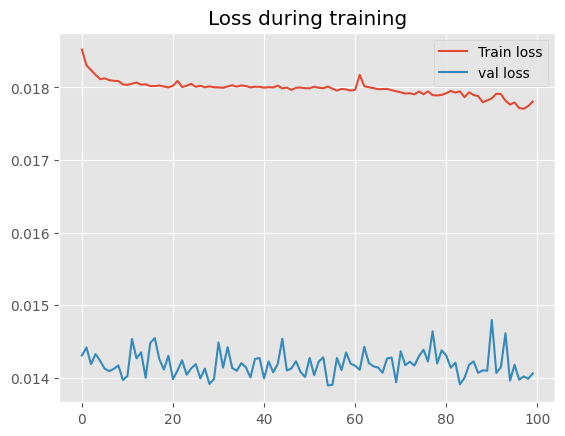

In [21]:
plt.style.use('ggplot')
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss during training')
plt.show()

In [23]:
# Review tập train
model = load_model(save_model_dir)

In [24]:
Y_1_predict = model.predict(X_train)
Y_1_predict.shape

105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step


(3343, 10)

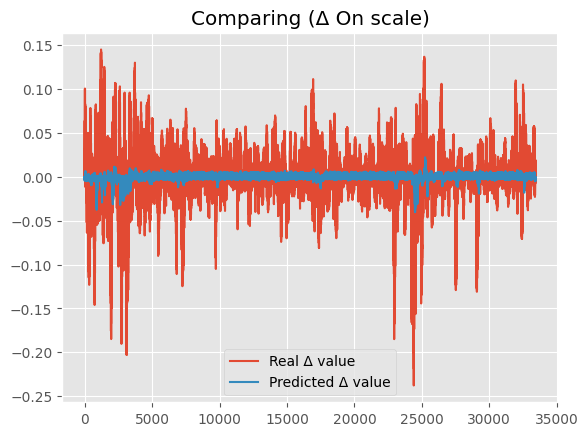

In [25]:
plt.style.use('ggplot')
plt.plot(Y_train.flatten(), label='Real Δ value')
plt.plot(Y_1_predict.flatten(), label='Predicted Δ value')
plt.legend()
plt.title('Comparing (Δ On scale)')
plt.show()

## 4. Tập kiểm thử

In [ ]:
scaled_train_data = scaler.fit_transform(test_data)

In [33]:
train_data

array([[0.63499711],
       [0.6354789 ],
       [0.6386587 ],
       ...,
       [0.58122952],
       [0.56407786],
       [0.56600501]])

In [34]:
test_data

array([[0.58315668],
       [0.58122952],
       [0.57737522],
       [0.57930237],
       [0.58315668],
       [0.57352091],
       [0.57352091],
       [0.56773945],
       [0.57737522],
       [0.57737522],
       [0.59452688],
       [0.59838119],
       [0.60030834],
       [0.6022355 ],
       [0.61746001],
       [0.63095009],
       [0.63673155],
       [0.64251301],
       [0.63673155],
       [0.63576797],
       [0.59645404],
       [0.59645404],
       [0.59259973],
       [0.60030834],
       [0.60416265],
       [0.60030834],
       [0.59838119],
       [0.59356331],
       [0.59452688],
       [0.59259973],
       [0.58122952],
       [0.58315668],
       [0.58508383],
       [0.59259973],
       [0.60030834],
       [0.60416265],
       [0.61187127],
       [0.60608981],
       [0.60994411],
       [0.61572557],
       [0.61938717],
       [0.61938717],
       [0.61842359],
       [0.62131432],
       [0.62324147],
       [0.62805936],
       [0.62902293],
       [0.628

In [38]:
test_interval = 100 # 100 hour prev = train_interval
predict_interval = 10 # 10 hour later

X_test, Y_test = [], []
data_len = len(data)

for i in range(0, len(test_data) - predict_interval):
    base_X = test_data[i, 0]
    j = len(train_data) + i
    X_test.append(np.array(data[j - test_interval : j]) - base_X)
    Y_test.append(np.array(data[j : j + predict_interval]) - base_X)

X_test = np.array(X_test)
Y_test = np.array(Y_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
Y_test = np.reshape(Y_test, (Y_test.shape[0], Y_test.shape[1]))

print("Shape of X_train:", X_test.shape)  # Expected: (number_of_samples, 100, 1)
print("Shape of Y_train:", Y_test.shape)  # Expected: (number_of_samples, 10)

Shape of X_train: (90, 100, 1)
Shape of Y_train: (90, 10)


In [27]:
model = load_model(save_model_dir)

In [39]:
Y_test_predict = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step


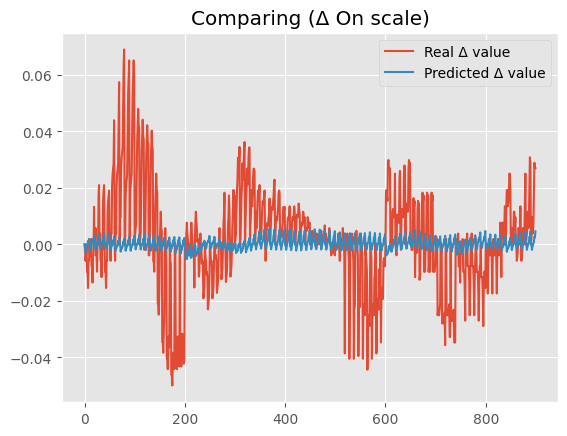

In [40]:
plt.style.use('ggplot')
plt.plot(Y_test.flatten(), label='Real Δ value')
plt.plot(Y_test_predict.flatten(), label='Predicted Δ value')
plt.legend()
plt.title('Comparing (Δ On scale)')
plt.show()